In [483]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib
import seaborn as sns


# read data from csv file
df = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
df = df.head(700)

# Check data information
df.info()


# Check data statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 20 columns):
dateCrawled            700 non-null object
name                   700 non-null object
seller                 700 non-null object
offerType              700 non-null object
price                  700 non-null int64
abtest                 700 non-null object
vehicleType            613 non-null object
yearOfRegistration     700 non-null int64
gearbox                648 non-null object
powerPS                700 non-null int64
model                  663 non-null object
kilometer              700 non-null int64
monthOfRegistration    700 non-null int64
fuelType               626 non-null object
brand                  700 non-null object
notRepairedDamage      555 non-null object
dateCreated            700 non-null object
nrOfPictures           700 non-null int64
postalCode             700 non-null int64
lastSeen               700 non-null object
dtypes: int64(7), object(13)
memory usage:

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.0,700.000000
mean,5655.174286,2002.172857,111.605714,125521.428571,6.047143,0.0,50151.921429
std,7702.125634,34.803764,73.394296,40077.440748,3.778079,0.0,26089.575996
min,0.000000,1111.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,100000.000000,3.000000,0.0,29221.000000
50%,2990.000000,2004.000000,105.000000,150000.000000,6.000000,0.0,49647.500000
75%,7625.000000,2009.000000,150.000000,150000.000000,9.000000,0.0,70390.750000
max,90500.000000,2018.000000,510.000000,150000.000000,12.000000,0.0,99867.000000


In [484]:
df['model'].head()


0     golf
1      NaN
2    grand
3     golf
4    fabia
Name: model, dtype: object

In [485]:

'''
수 데이터들의 통계적인 수치들을 확인할 수 있었다.
- Price는 값이 0인 데이터들도 존재한다.
- yearOfRegistration은 1000년대 초반 데이터부터 존재했다.
- kilometer는 150000인 값이 많았으며, 최저와 최고 값의 차이가 매우 컸다.
- powerPS는 값이 0인 데이터들도 존재한다.
- nrOfPicutrees는 모든 값이 0을 가지고 있었다.
'''


print(len(df['name'].unique()))
print(len(df['postalCode'].unique()))
# postal code의 값은 주소 코드를 의미하는데 매우 많은 값으로 분포되어 있었다.

print(df['seller'].value_counts())
print(df['offerType'].value_counts())
# seller, offer type는 거의 모두 하나의 값으로 다 수렴하고 있었다.


689
643
privat    700
Name: seller, dtype: int64
Angebot    700
Name: offerType, dtype: int64


['abtest', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']


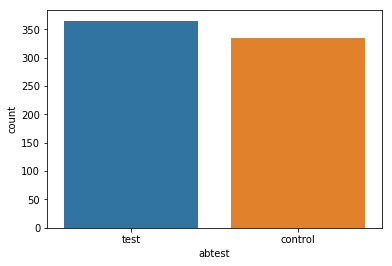

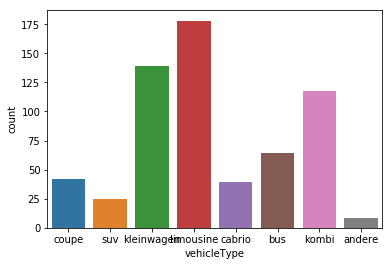

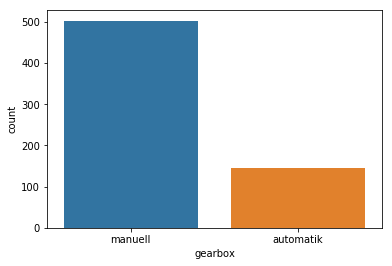

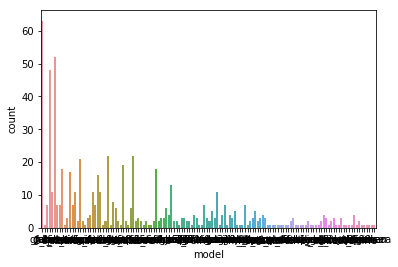

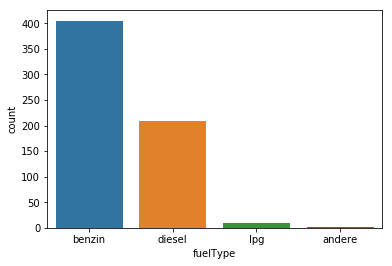

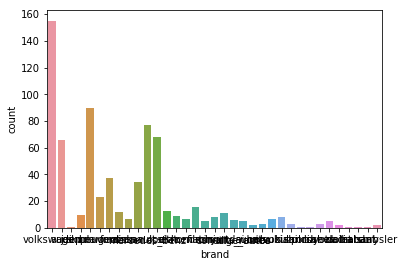

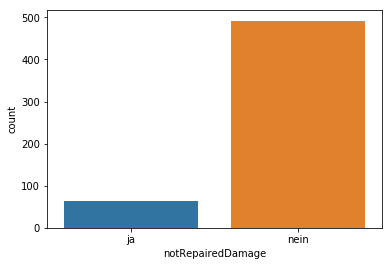

'\n카테고리 데이터들의 히스토그램을 볼 수 있었다.\ngearbox와 notRepairedDamage의 경우, 값이 한쪽으로 많이 쏠려있었다.\nfuelType의 경우에도 다른 값에 비해 너무 적은 데이터들이 존재했다.\n'

In [486]:

# Restructuring -> Vertical Decomposition
# drop low impact data on price
# 1. 데이터가 대부분 하나의 값으로 수렴하는 경우 (seller, offerType, nrOfPictures)
# 2. 목표인 가격을 예측하는 것과 생관없는 경우 (dateCrawled, lastSeen, dateCreated)
# 3. 각기 다 다른 값을 가지는 경우 (name, postalCode)
df.drop(['seller', 'offerType', 'nrOfPictures', 'dateCrawled', 'lastSeen', 'dateCreated', 'postalCode', 'name'], axis='columns', inplace=True)


# Remove unusable data(redundant data)
df = df.drop_duplicates(['price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])



category_feature = [col for col in df.columns if df[col].dtypes == 'object' and col != 'name']
print(category_feature)

for col in category_feature:
    sns.countplot(x = col, data = df)
    plt.show()
    
'''
카테고리 데이터들의 히스토그램을 볼 수 있었다.
gearbox와 notRepairedDamage의 경우, 값이 한쪽으로 많이 쏠려있었다.
fuelType의 경우에도 다른 값에 비해 너무 적은 데이터들이 존재했다.
'''
    

['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']


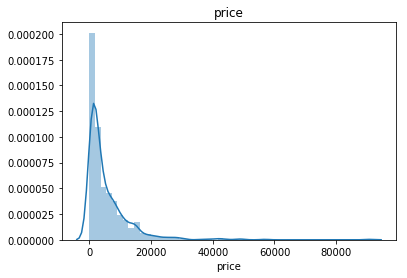

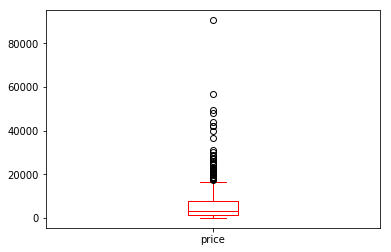

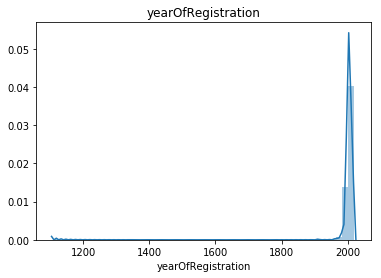

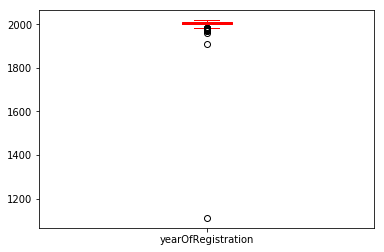

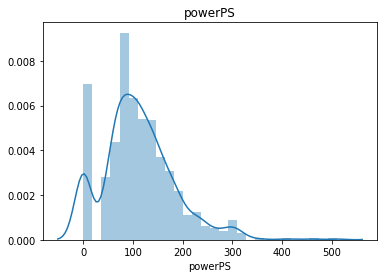

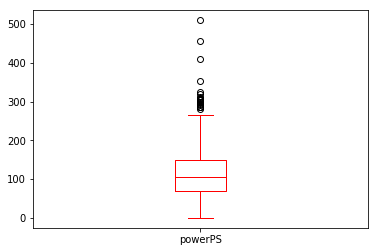

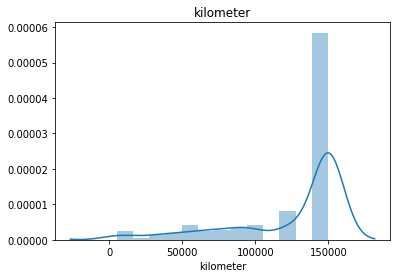

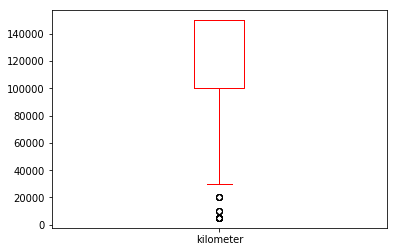

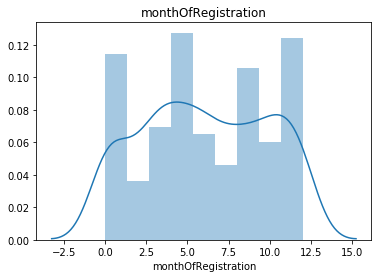

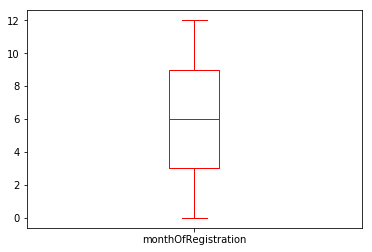

In [487]:

numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

def dist_box(df, feature_list):
    for col in feature_list:
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()
        df[col].plot(kind='box', color='red')
        plt.show()
# 수 데이터들의 분포와 box plot을 볼 수 있다.

dist_box(df, numerical_feature)
'''
- price, yearOfRegistration 데이터 분포가 skewed한 형태를 띈다. (분포가 몰려있다)
- 모든 feature의 데이터들에서 조금씩의 outlier들이 존재한다.

'''
# 앞을 통해 본 데이터들로 Wrong data, Outlier를 제거한다.
# Remove the outliers and wrong data
df = df[
        (df.yearOfRegistration <= 2019)
    & (df.yearOfRegistration >= 1970)
    & (df.price >= 100)
    & (df.price <= 60000)
    & (df.powerPS >= 10)
    & (df.powerPS <= 400)
    ]

 



In [488]:

# Missing data
df.isnull().sum()

# 'model' of car
df = df[df['model'].notnull()]

# Replace null with others
# Replace with the most value according to model type.
# value_counts() --> 맨 위 최빈값.
# 모델 종류를 다 돌아가면서 VehicleType, fuleType, gearbox 중 missing 값인 경우, 해당 모델의 최빈값을 가져와 채움.

for i in range(len(df['model'].unique())) :
    df["vehicleType"].fillna(df.vehicleType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["fuelType"].fillna(df.fuelType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["gearbox"].fillna(df.gearbox[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)

# null in 'notRepairedDamage' is one of the deciding factors for price prediction.
# -> replace null with 'nein' that means "NO" in English ==> mode value
df["notRepairedDamage"].fillna(value='nein', inplace=True)

# Check the misting data is processed.
print(df.isnull().sum())
print(len(df))



price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64
574


In [489]:
# columns that value is string
les = {}


# label encoder
# encode string columns to 0~k-1 labels
for l in category_feature:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(df[l].astype(str))
    tr = les[l].transform(df[l].astype(str))
    df.loc[:, l + '_encode'] = pd.Series(tr, index=df.index)

# extract only necessary columns to analysis
df = df[ ['price'
                ,'yearOfRegistration'
                ,'powerPS'
                ,'kilometer'
                ,'monthOfRegistration']
                + [x+"_encode" for x in category_feature]]


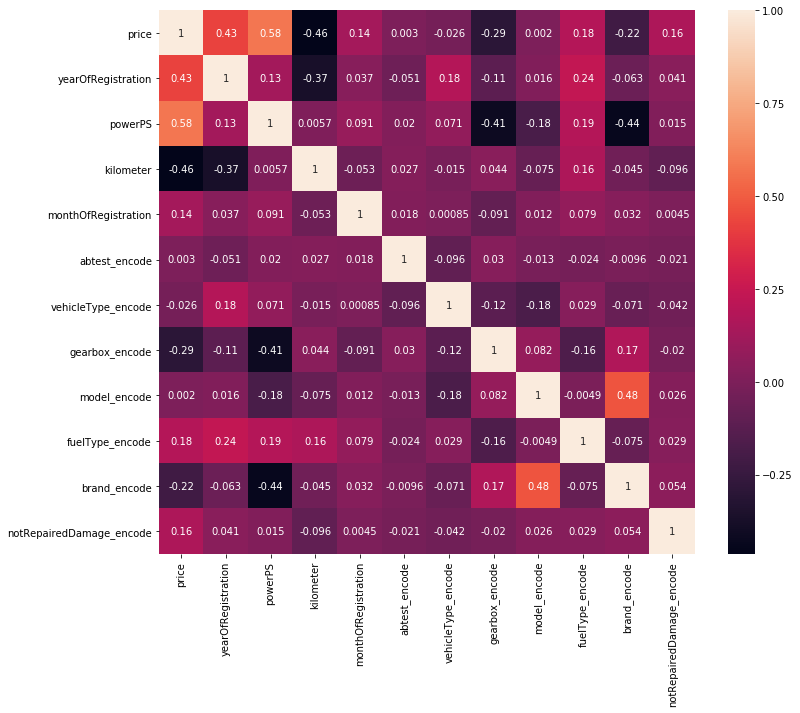

In [490]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )
# plot the correlation heatmap
sns.heatmap(corr,
        annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [491]:
# price와 제일 correlation 관계가 없는 abtest, vehicleType, model을 삭제
df.drop(['abtest_encode', 'vehicleType_encode', 'model_encode'], axis='columns', inplace=True)


In [492]:

# normalization
df['price']= np.log(df['price'])

# standardization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

#scaler = StandardScaler()
#scaler = RobustScaler()
scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
# 제일 정확도가 높은 MinMaxScaler 사용
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)


# Split X and Y
# Y --> price column
# X --> data without price column
Y = df['price']
X = df.drop(['price'], axis=1, inplace=False)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


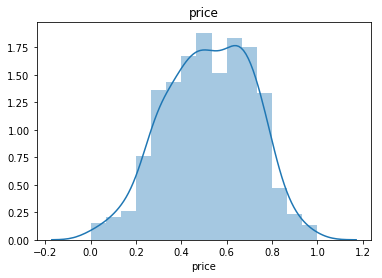

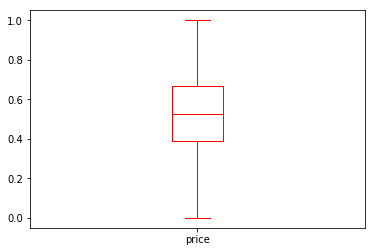

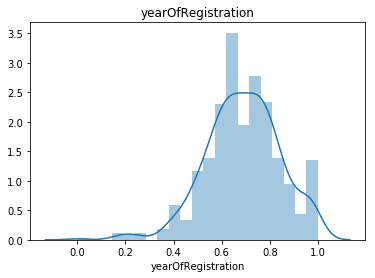

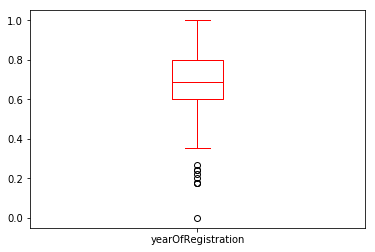

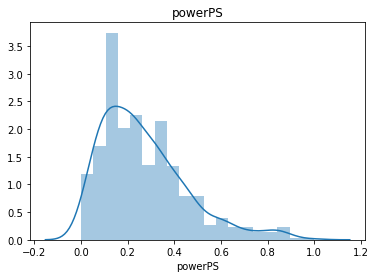

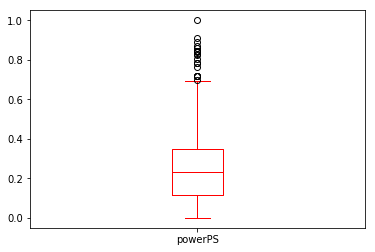

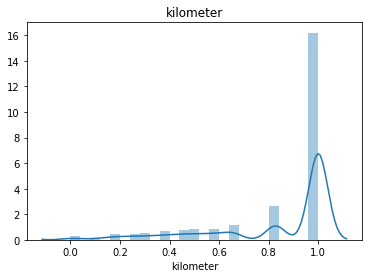

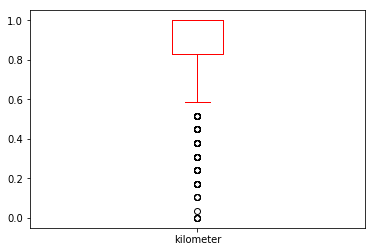

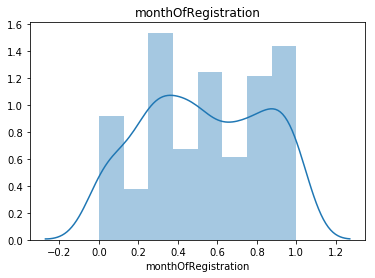

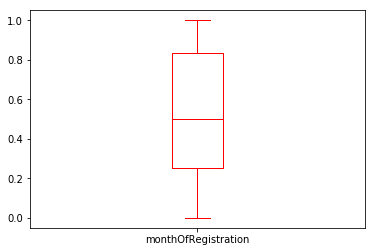

In [493]:
dist_box(df, numerical_feature)

In [494]:

# In[23]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# In[40]:


# Divide data into training data and test data (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

from sklearn.tree import DecisionTreeRegressor


decisionTree = DecisionTreeRegressor().fit(X_train, y_train) # make decisionTreeRegressor model for predict dependent value
predictDecision = decisionTree.predict(X_test) # predict dependent value to test data and assign 'predictDecision'
score = decisionTree.score(X_test, y_test) # accuracy for result of predictition
print("Decision Tree Score : ",score)





# In[45]:

# Using ensemble learning for regression
# ==> RandomForestRegressor
# n_estimators: The number of trees in the forest
# oob_score: out of bagging score
randomForest = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123)
randomForest.fit(X_train, y_train)


# In[47]:

# predict data using X_test
predicted = randomForest.predict(X_test)
y_predict = pd.Series(predicted) # make series of pandas

# print test data, predict data
print("\nTEST")
print(y_test)
print("PREDICT")
print(y_predict)


# In[19]:


# Resets index to compare original test data with predicted data
y_test = y_test.reset_index(drop=True)
y_predict = y_predict.reset_index(drop=True)

# # Print the data using the index in order that the values are less different.
# temp = (y_test - y_predict).abs().sort_values().index
# for i in temp:
#     print("Original: ", y_test.iloc[i])
#     print("Predicted: ", y_predict.iloc[i])
#     print()

# print out of bag score
# Testing with samples not used in training.
print(f'Out-of-bag score estimate: {randomForest.oob_score_:.3}')


# In[20]:


# MAPE(mean absolute percentage error)
# : measure of prediction accuracy of a forecasting method
def MAPE(actual, predict):

    sum_actuals = sum_errors = 0

    for actual_val, predict_val in zip(actual, predict):
        abs_error = actual_val - predict_val # calculate error
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    # calculate and print MAPE
    mean_abs_percent_error = sum_errors / sum_actuals
    print("MAPE: ")
    print(mean_abs_percent_error)
    # calculate accuracy
    print("Accuracy using MAPE: ")
    print(1-mean_abs_percent_error)


# In[15]:
MAPE(y_test, y_predict)



Decision Tree Score :  0.5754009745552151

TEST
329    0.335515
444    0.535169
205    0.486724
151    0.504467
545    0.618359
85     0.387744
483    0.735082
356    0.525543
178    0.350168
492    0.590453
352    0.701210
435    0.669633
150    0.791017
540    0.314337
54     0.647147
534    0.572708
155    0.689449
181    0.319466
500    0.350168
482    0.048444
470    0.883567
9      0.319297
229    1.000000
331    0.664287
35     0.744786
310    0.628063
57     0.702081
286    0.679823
249    0.787927
478    0.590487
         ...   
55     0.775477
496    0.436188
164    0.492849
523    0.403794
309    0.319297
517    0.317773
426    0.403794
268    0.568961
421    0.259403
26     0.520516
490    0.750742
204    0.523049
429    0.771512
267    0.606537
159    0.727776
105    0.647147
263    0.281889
114    0.646907
242    0.621189
525    0.836111
402    0.860834
190    0.301724
313    0.350168
49     0.466820
528    0.335515
468    0.587085
22     0.608212
157    0.756494
553    0